In [ ]:
'''
Deep Learning Stock Price Predictor 
Author: Gil Akos
Objective: Create Deep Learning Model with Keras LSTM
Reference: http://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

TEST LOOKBACK VALUES FOR SINGLE LSTM USING VOLUME AS INPUT
'''

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Import required libraries for Machine Learning
import math
import numpy as np
# Fix random seed for reproducibility
np.random.seed(7)
import pandas as pd

# Import Keras Libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.metrics import mean_squared_error

# Import required libraries for Yahoo Finance API
import yahoo_finance as yf
from yahoo_finance import Share

# Import required libraries for visualization and printing
from pprint import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (18, 12)
import matplotlib.dates as mdates

# Import utility libraries
import utilities as util
import datetime
import time

Using TensorFlow backend.


In [2]:
# Set Benchmark Dates based on Machine Learning for Trading course 1/1/09-6/18/15
date_start, date_end = '1995-01-01', '2015-06-18'#'2015-06-18'

# Set Additional Tickers
tick_0 = 'SPY'
tick_1 = 'GE'
tick_2 = 'MSFT'
tick_3 = 'AAPL'

# Set Baseline Model Ticker
base_ticker = tick_0

In [3]:
#Request Stock Data
stock_data = Share(base_ticker)
stock_historical = stock_data.get_historical(date_start,date_end)

#pprint(stock_historical)

#Define columns of data to keep from historical stock data
stock_item = []
stock_date = []
stock_close = []
stock_volume = []

#Loop through the stock data objects backwards and store factors we want to keep
i_counter = 0
for i in xrange(len(stock_historical)-1,-1,-1):
    d = stock_historical[i]
    stock_item.append(i_counter)
    stock_date.append(d['Date'])
    stock_close.append(d['Adj_Close'])
    stock_volume.append(d['Volume'])
    i_counter += 1

#Create a dataframe for stock data
stock_df = pd.DataFrame()
    
#Add factors to dataframe
stock_df['Item'] = stock_item
stock_df['Date'] = stock_date
stock_df['Adj_Close'] = pd.to_numeric(stock_close)
stock_df['Volume'] = pd.to_numeric(stock_volume)

#Print the dataframe head and tail
print(stock_df.head())
print("---")
print(stock_df.tail())

   Item        Date  Adj_Close  Volume
0     0  1995-01-03  30.707108  324300
1     1  1995-01-04  30.853865  351800
2     2  1995-01-05  30.853865   89800
3     3  1995-01-06  30.885254  448400
4     4  1995-01-09  30.916713   36800
---
      Item        Date   Adj_Close     Volume
5147  5147  2015-06-12  202.337412  135382400
5148  5148  2015-06-15  201.470299  124384200
5149  5149  2015-06-16  202.568649   85308200
5150  5150  2015-06-17  202.896224  126708600
5151  5151  2015-06-18  205.006216  165867900


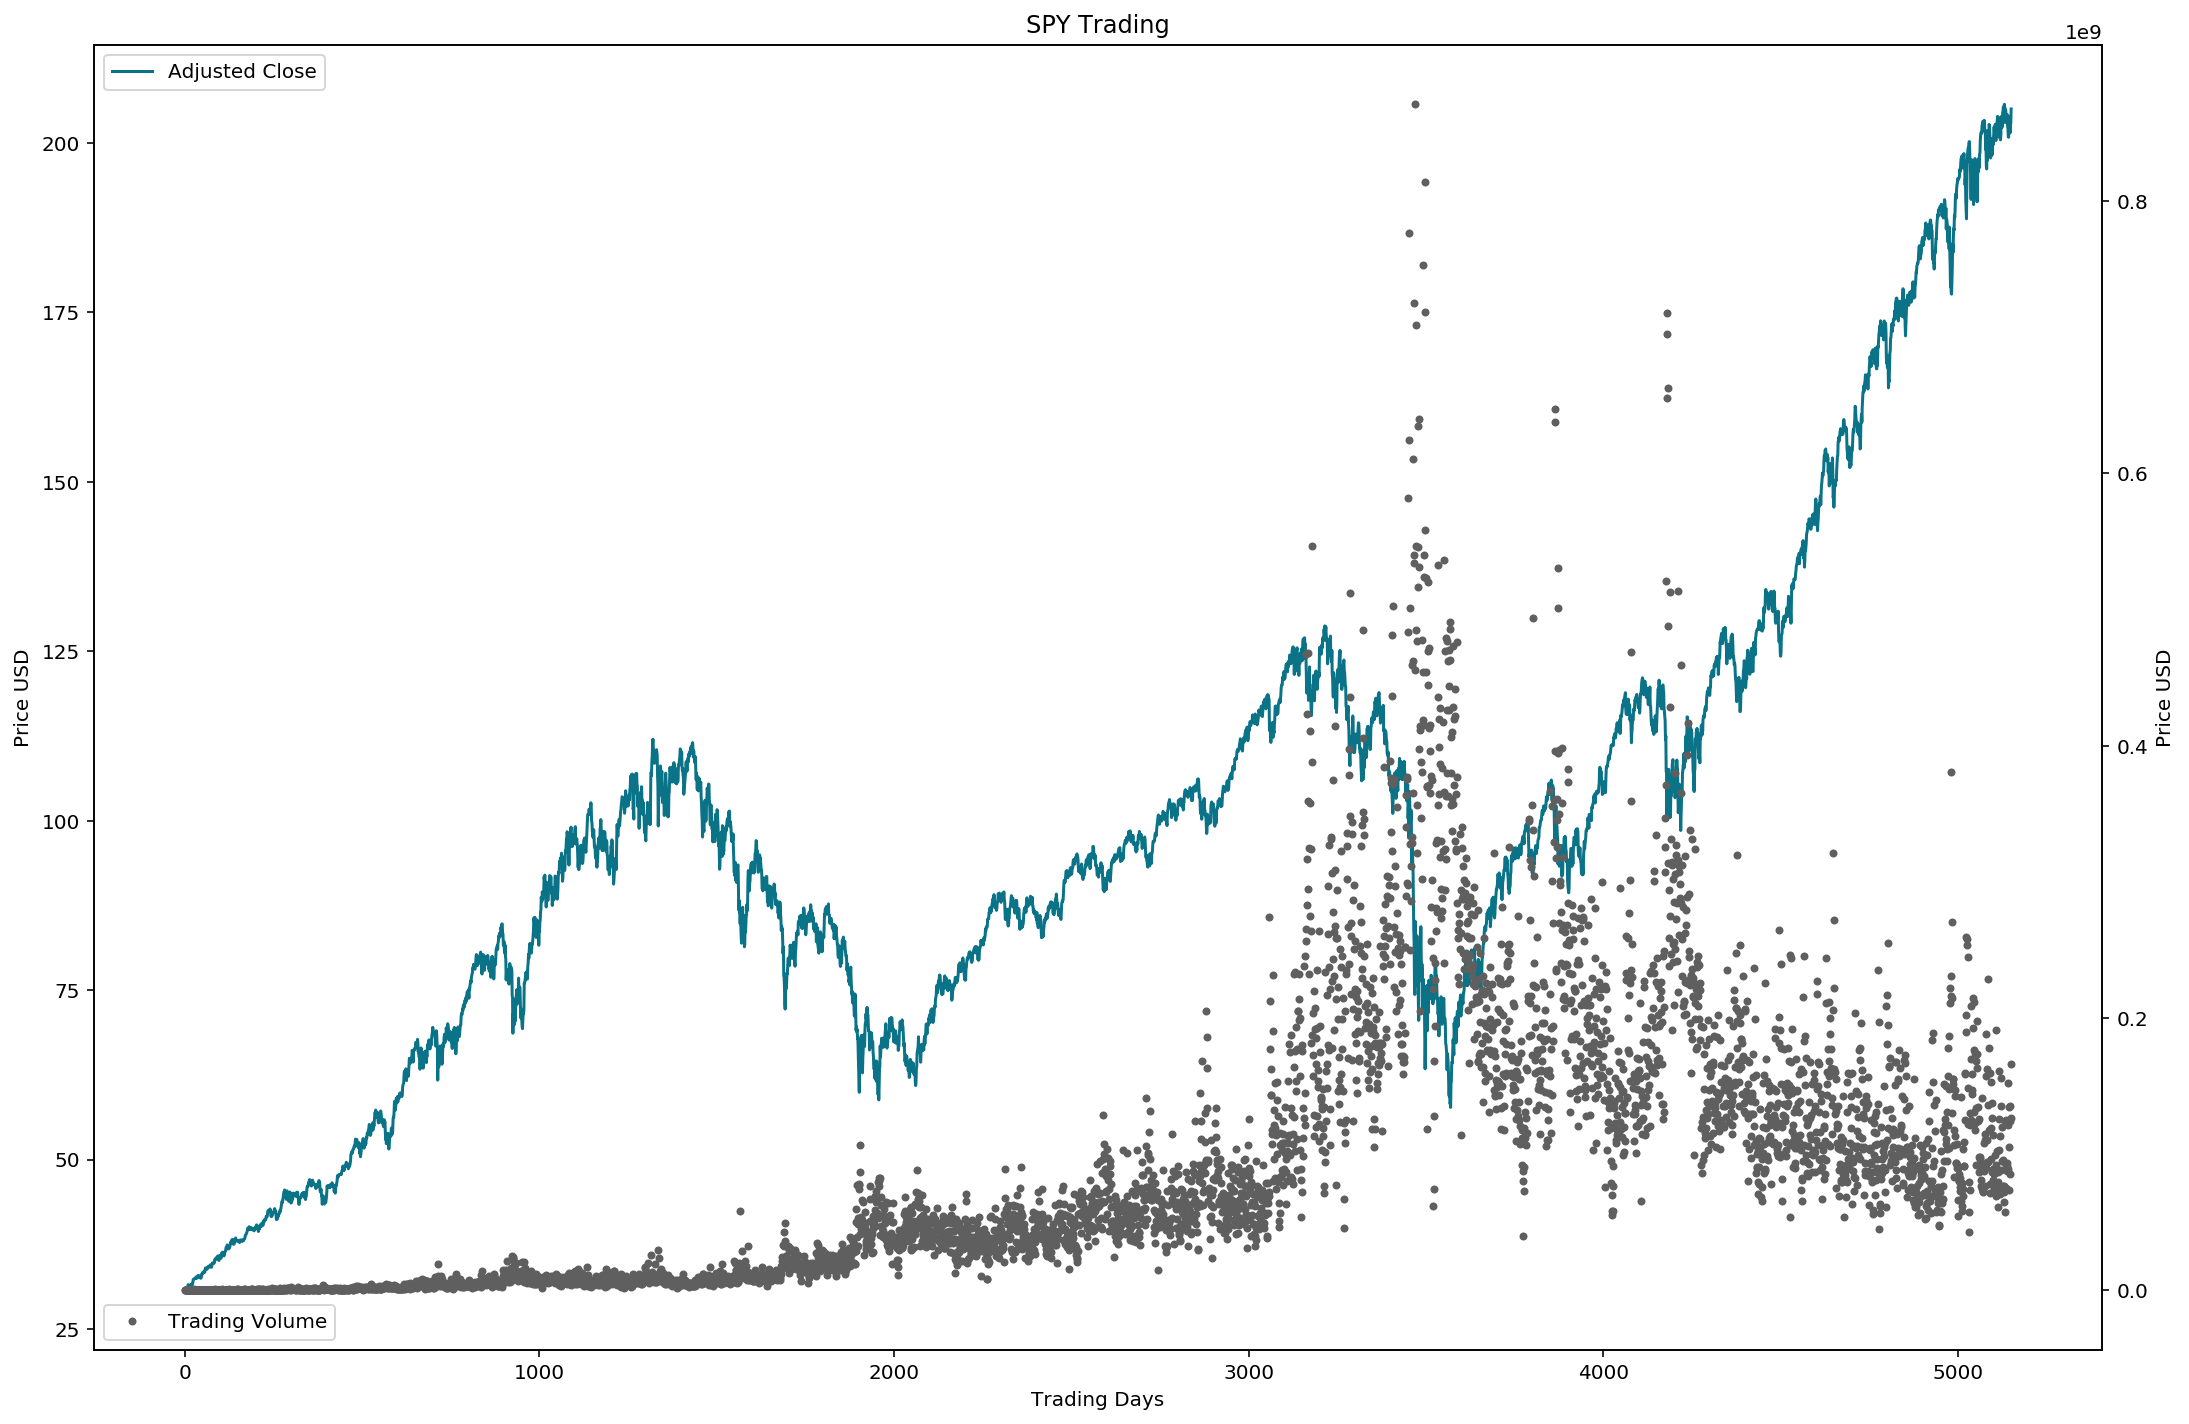

In [4]:
# Plot Basic Data
fig, ax1 = plt.subplots()
# Axis 1 - Adjusted Close
ax1.plot(stock_df['Item'], stock_df['Adj_Close'], '#0A7388', label='Adjusted Close')
# Set X Axis label
ax1.set_xlabel('Trading Days')
# Set Y Axis label
ax1.set_ylabel('Price USD')

# Axis 2 - Volume
ax2 = ax1.twinx()
ax2.plot(stock_df['Item'], stock_df['Volume'], 'r.', color='#5f5f5f', label='Trading Volume')
# Set Y Axis label
ax2.set_ylabel('Volume')

# Add labels
plt.ylabel('Price USD')
plt.xlabel('Trading Days')

# Add title and legend
ax1.set_title(base_ticker + ' Trading')
ax1.legend(loc='upper left')
ax2.legend(loc='lower left')

plt.show()

In [5]:
#Create numpy arrays for features and targets
#X_day_all = []
vol_all = []
close_all = []

#Convert dataframe columns to numpy arrays for scikit learn
for index, row in stock_df.iterrows():
    #print([np.array(row['Item'])])
    #X_day_all.append([(row['Item'])])
    vol_all.append([(row['Volume'])])
    close_all.append([(row['Adj_Close'])])

#pprint(vol_all)
#pprint(close_all)

In [21]:
# Reshape into t and t+1
look_back = 5 #50
tt_split = (1.0-.315)

#X_day_train_t, X_day_train_t1, X_day_test_t, X_day_test_t1 = create_dataset(X_day_all, look_back, tt_split, True)
X_vol_train, y_vol_train, X_vol_test, y_vol_test, vol_bounds = \
    util.create_dataset(close_all, look_back, tt_split, True)
X_close_train, y_close_train, X_close_test, y_close_test, close_bounds = \
    util.create_dataset(close_all, look_back, tt_split, True)

pprint(X_vol_train)
print('--')
pprint(y_close_train)

array([[[ 0.        ],
        [ 0.00083865],
        [ 0.00083865],
        [ 0.00101802],
        [ 0.00119779]],

       [[ 0.00083865],
        [ 0.00083865],
        [ 0.00101802],
        [ 0.00119779],
        [ 0.00137755]],

       [[ 0.00083865],
        [ 0.00101802],
        [ 0.00119779],
        [ 0.00137755],
        [ 0.00149714]],

       ..., 
       [[ 0.24640263],
        [ 0.24519257],
        [ 0.25516354],
        [ 0.26131068],
        [ 0.27447625]],

       [[ 0.24519257],
        [ 0.25516354],
        [ 0.26131068],
        [ 0.27447625],
        [ 0.27394382]],

       [[ 0.25516354],
        [ 0.26131068],
        [ 0.27447625],
        [ 0.27394382],
        [ 0.27694481]]])
--
array([[ 0.00137755],
       [ 0.00149714],
       [ 0.00155732],
       ..., 
       [ 0.27394382],
       [ 0.27694481],
       [ 0.263392  ]])


In [22]:
# Create Keras Model
# http://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

# Set up hyperparameters
batch_size = 1
epochs = 1 # 200
n_nodes = [16]

# Create the LSTM model
model = Sequential()
model.add(LSTM(n_nodes[0], batch_input_shape=(batch_size, look_back, 1)))
model.add(Dense(1))

# Compile the model
start = time.time()
model.compile(loss='mean_squared_error', optimizer='adam')
print 'compilation time : ', time.time() - start

compilation time :  0.573699951172


In [23]:
# Train the model
model.fit(X_vol_train, 
          y_close_train, 
          nb_epoch=epochs, 
          batch_size=batch_size, 
          verbose=2)

Epoch 1/1
18s - loss: 1.8639e-04


In [24]:
# Generate predictions for training
#testPredict = model.predict(X_vol_test, batch_size=batch_size)
testPredict = util.predict_sequences(model, X_vol_test)
pprint(testPredict)

[[0.26621646],
 [0.26578957],
 [0.26142213],
 [0.25492409],
 [0.24909809],
 [0.24233472],
 [0.2362642],
 [0.2331135],
 [0.22609141],
 [0.22412524],
 [0.22264785],
 [0.22180712],
 [0.22153544],
 [0.22486717],
 [0.22945502],
 [0.23074284],
 [0.22917396],
 [0.22694662],
 [0.22599182],
 [0.22329277],
 [0.22418866],
 [0.22904131],
 [0.23365164],
 [0.23188794],
 [0.2307815],
 [0.22917247],
 [0.22540379],
 [0.21768996],
 [0.21281108],
 [0.20732695],
 [0.20173463],
 [0.19404072],
 [0.19288263],
 [0.19151795],
 [0.1892806],
 [0.18557024],
 [0.17949191],
 [0.17195207],
 [0.16811049],
 [0.16209361],
 [0.1579847],
 [0.15525168],
 [0.15835488],
 [0.16107282],
 [0.1685603],
 [0.17570201],
 [0.1817998],
 [0.18761951],
 [0.19459522],
 [0.19782013],
 [0.19796532],
 [0.20499441],
 [0.20804793],
 [0.21068665],
 [0.21557796],
 [0.21877855],
 [0.21469501],
 [0.212758],
 [0.21264946],
 [0.21489805],
 [0.21897975],
 [0.22320622],
 [0.22374842],
 [0.22419101],
 [0.22745684],
 [0.2301535],
 [0.23098949],
 [0.2

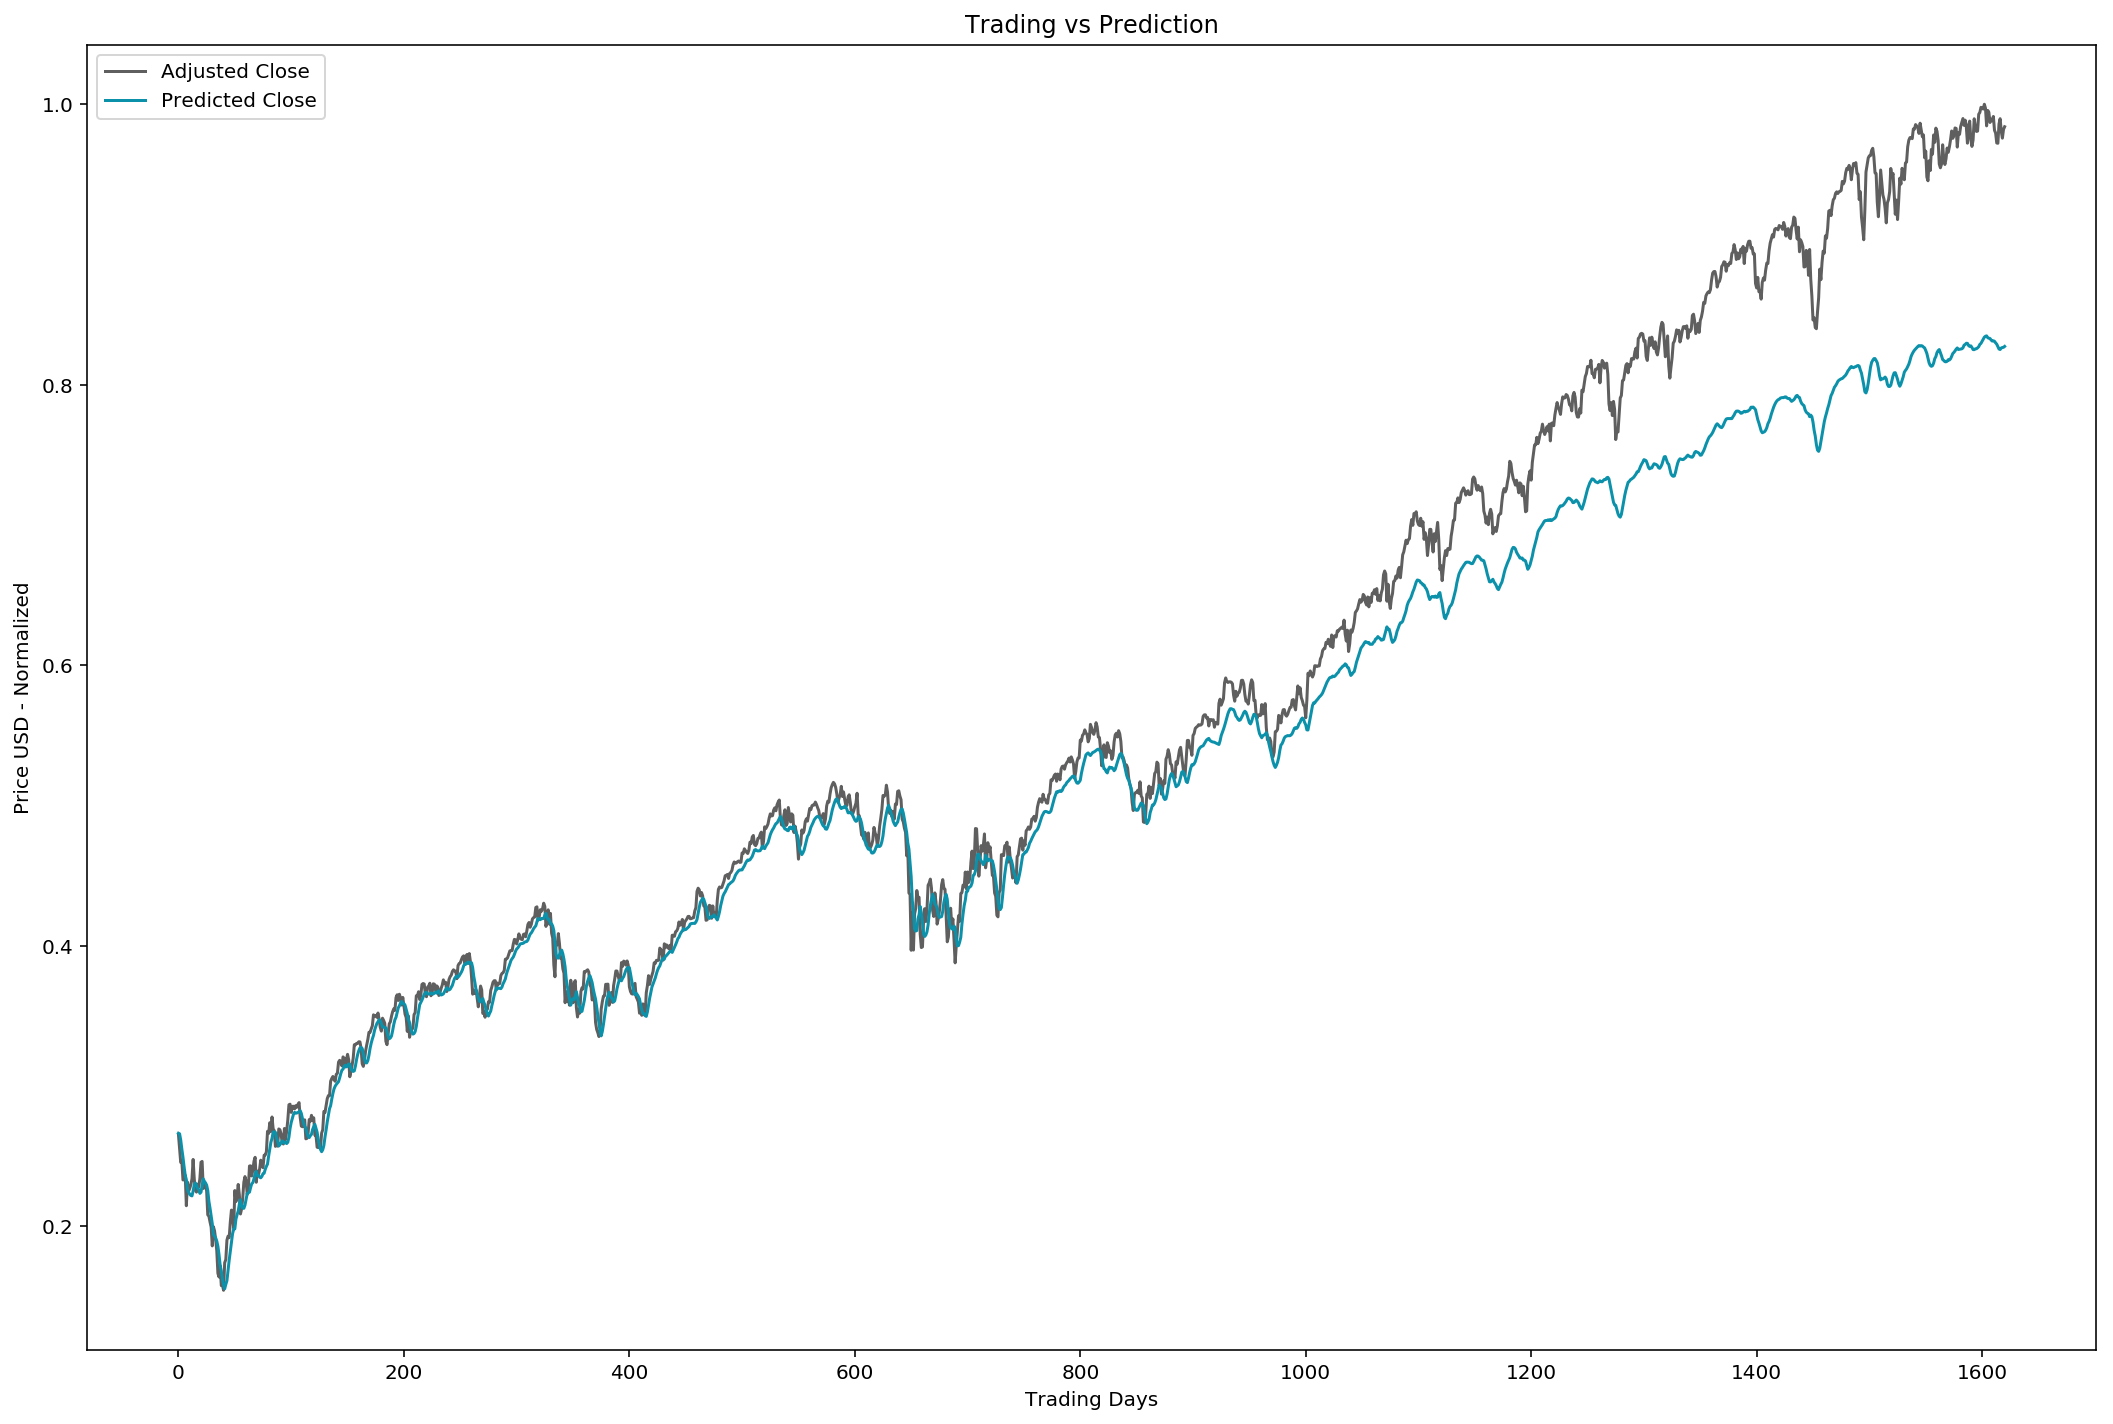

In [25]:
# Plot the predictions

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Add labels
plt.ylabel('Price USD - Normalized')
plt.xlabel('Trading Days')
# Plot actual and predicted close values

plt.plot(y_close_test,'#5F5F5F', label='Adjusted Close')
plt.plot(testPredict, '#0C91AB', label='Predicted Close')

# Set title
ax.set_title('Trading vs Prediction')
ax.legend(loc='upper left')

plt.show()

In [26]:
# The mean squared error
testScore = model.evaluate(X_vol_test, y_close_test, batch_size=batch_size, verbose=0)
print('Test Score: %.4f MSE (%.4f RMSE)' % (testScore, math.sqrt(testScore)))

Test Score: 0.0039 MSE (0.0622 RMSE)


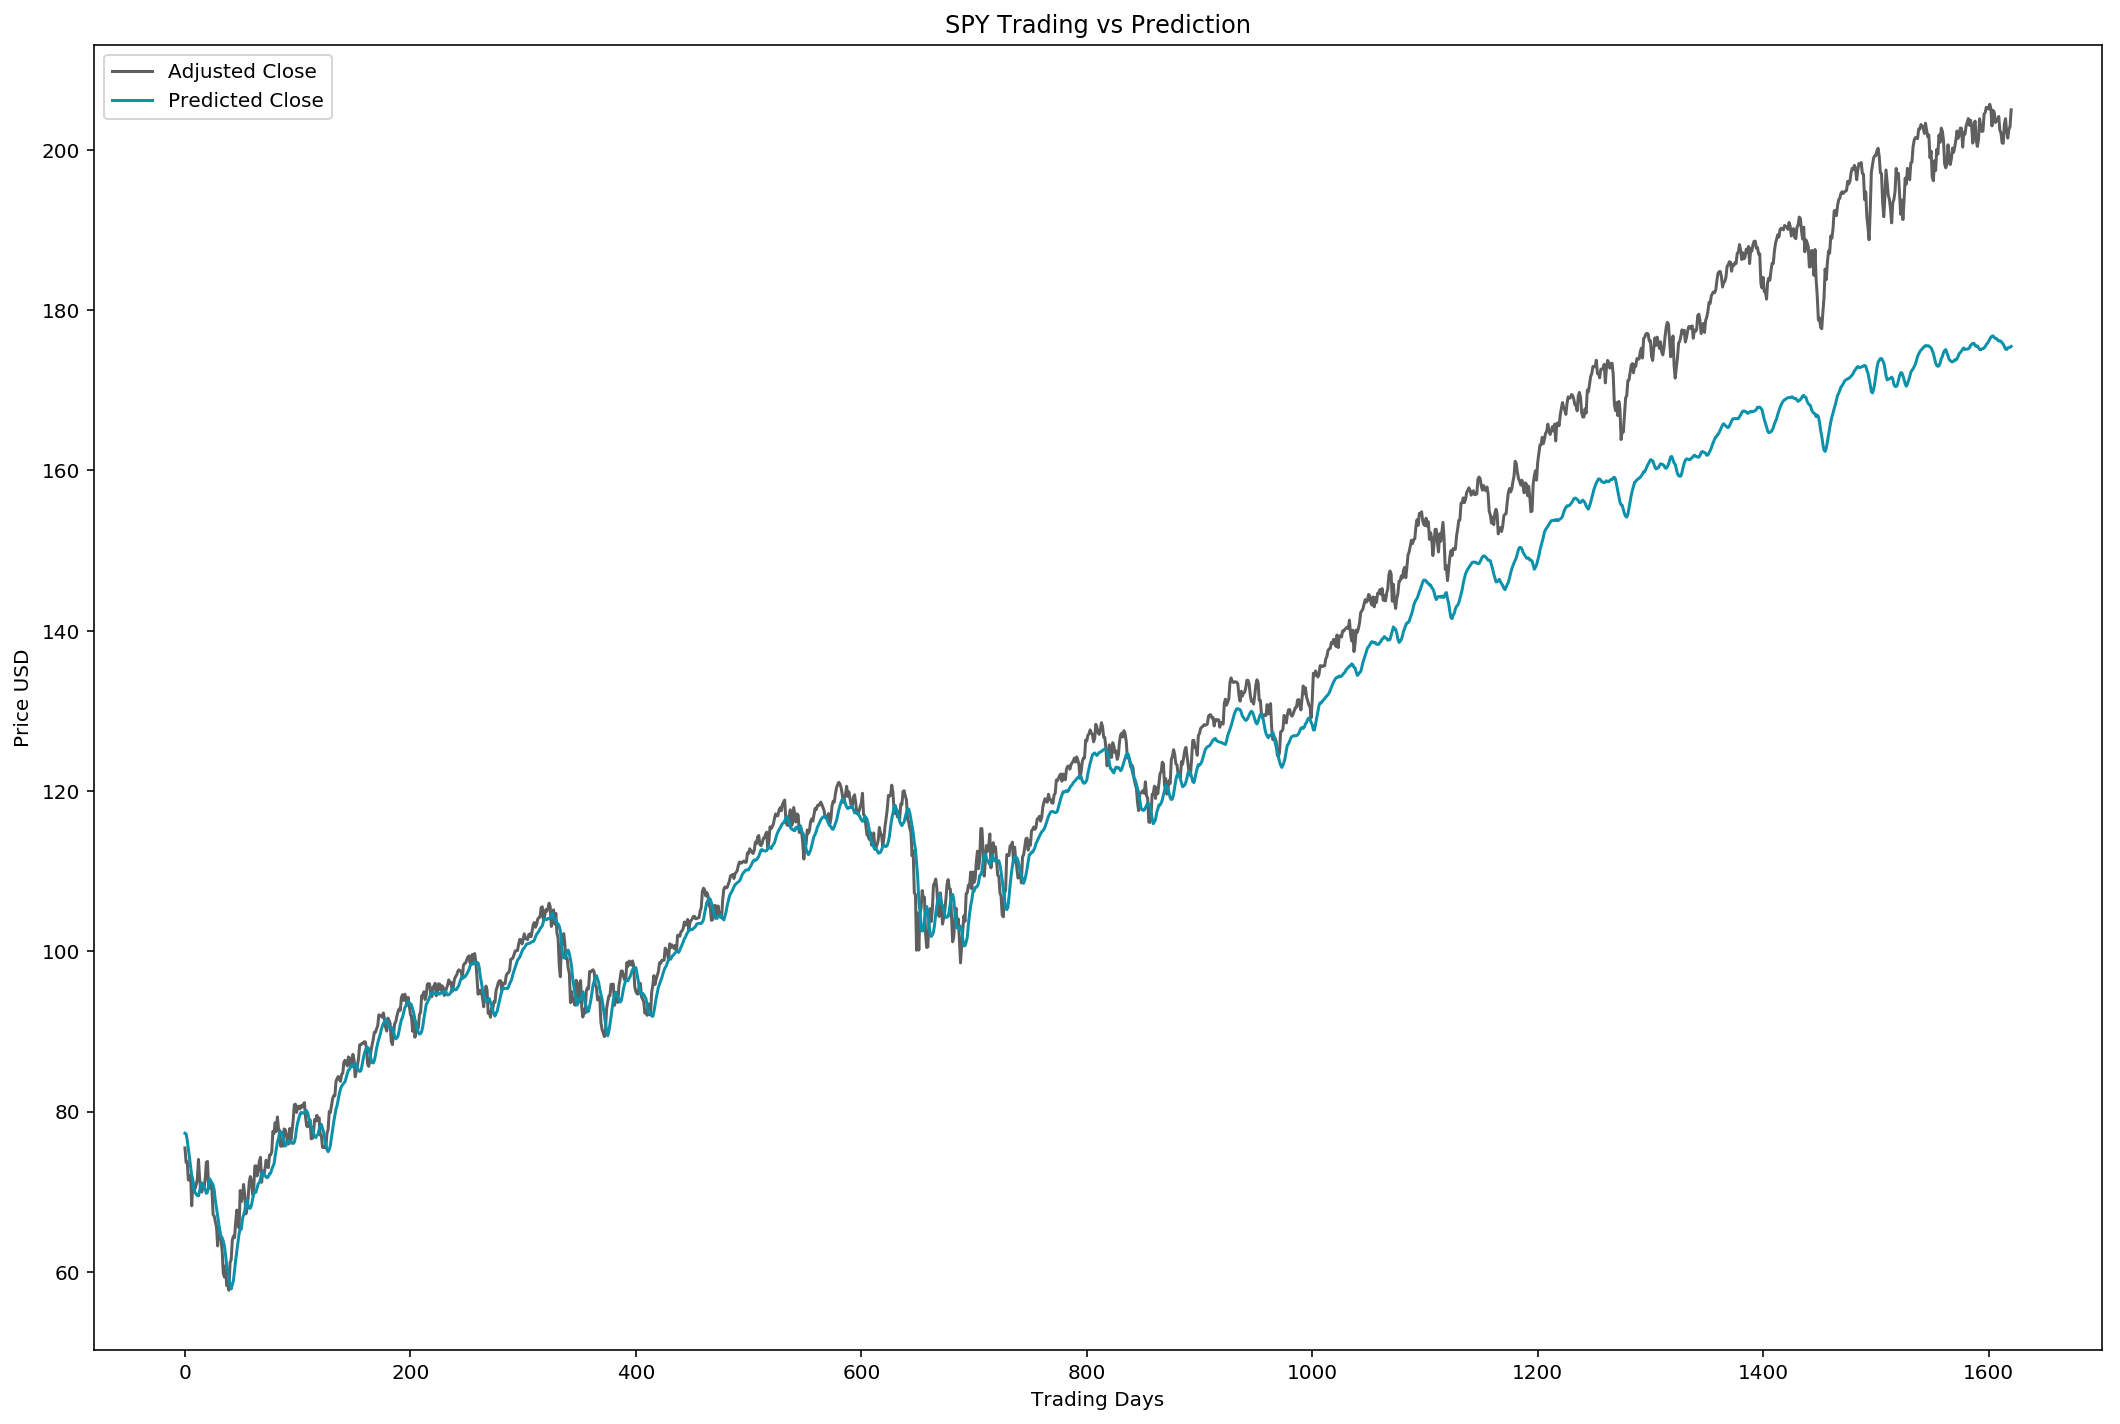

In [27]:
# Plot the predictions
close_plot = close_all[-y_close_test.shape[0]:]

pred_seq = np.array(testPredict)
#pprint(pred_seq)
preds_seq_plot, r = util.scale_range(pred_seq, input_range=[0.0,1.0], target_range=close_bounds)
#pprint(preds_seq_plot)

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Add labels
plt.ylabel('Price USD')
plt.xlabel('Trading Days')
# Plot actual and predicted close values

plt.plot(close_plot,'#5F5F5F', label='Adjusted Close')
plt.plot(preds_seq_plot, '#0C91AB', label='Predicted Close')

# Set title
ax.set_title(base_ticker + ' Trading vs Prediction')
ax.legend(loc='upper left')


# Log of Results:

### SPY
Epochs: 1 Lookback: 1 NumNodes: 16 Test Score: 0.0001 MSE (0.0076 RMSE)

Epochs: 1 Lookback: 3 NumNodes: 16 Test Score: 0.0021 MSE (0.0454 RMSE)

Epochs: 1 Lookback: 5 NumNodes: 16 Test Score: 0.0039 MSE (0.0622 RMSE)

Epochs: 1 Lookback: 10 NumNodes: 16 

Epochs: 1 Lookback: 20 NumNodes: 16 

Epochs: 1 Lookback: 40 NumNodes: 16 

### GE
XX

### MSFT
XX

### AAPL
XX